<a href="https://colab.research.google.com/github/ga96jul/ML_COMM_Project/blob/master/EM_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# load packages and data
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pdb;
data = np.load('EM_data.npy')

N = data.size

In [0]:
def ask_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    
    X = np.arange(-M+1,M,2,dtype=int)
    
    X = X.reshape((1,X.size))
    X = X/np.sqrt(np.mean(X**2))
    
    return X

def qam_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    if M == 128:
        M_ask = int(np.sqrt(144))
        tmp = ask_cstll(M_ask).reshape((M_ask,1))
        tmp = tmp + 1j*tmp.T
        X = tmp.flatten()
        X = X/np.sqrt(np.mean(np.abs(X)**2))
        for i in range(16):
            idx = np.argmax(np.abs(X))
            X = np.delete(X,idx)

    else:
        M_ask = int(np.sqrt(M))
        tmp = ask_cstll(M_ask).reshape((M_ask,1))
   
        tmp = tmp + 1j*tmp.T
        X = tmp.flatten()
        X = X/np.sqrt(np.mean(np.abs(X)**2))
    
    return X

In [0]:
# initial plot of data

plt.scatter(data.real,data.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.draw()

In [0]:
# k-means algorithm with only output values known
# we choose a maximum value for the k-QAM
# iteratively compute every valid M-QAM constellation to the maximum k
# we choose the k that minimizes the uncertainty
# constraint of equidistance of each point

def k_means(y,k,iter):
    # intialize k constellation points according to a M-QAM constellation
    C = qam_cstll(k)
    # init paras
    N = y.size
    iter_cnt = 0
    C0 = C
    K = C0.size
    conv_flag = 0
    s_real = np.zeros((K,), dtype = float)
    s_imag = np.zeros((K,), dtype = float)
    temp_C = np.zeros((K,), dtype = complex)  
    while (iter_cnt < iter and conv_flag == 0):
        # calculate euclidian distance
        tmp = np.abs(y.reshape((N,1)) - C.reshape((1,K)))
        # assign every data point a label
        tmp_idx = np.argmin(tmp,axis=1)
        # calculate change of constellation points
        for j in range(K):
            idx = (tmp_idx == j)
            if np.sum(idx) > 0:
                temp_C[j] = np.sum(y[idx])/np.sum(idx)
                s_real[j] = temp_C[j].real/C[j].real
                s_imag[j] = temp_C[j].imag/C[j].imag
        # calculate a constant the points spread out to keep equidistant constraint
        const_real = np.sum(s_real)/K 
        const_imag = np.sum(s_imag)/K
        constant = (const_imag + const_real)/2
        #C = const_real*C.real + 1j * const_imag*C.imag
        C = constant * C
        #pdb.set_trace()
        iter_cnt = iter_cnt + 1
    data_out = {'C':C,'N_real':const_real,'N_imag':const_imag}
    return data_out




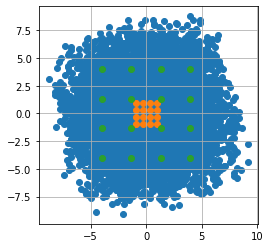

In [206]:
K = 16

data_out = k_means(data,K,1000)
C_1 = data_out['C']
pC = qam_cstll(K)
plt.scatter(data.real,data.imag)
plt.scatter(pC.real,pC.imag)
plt.scatter(C_1.real,C_1.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.draw()


In [0]:
# EM Algorithm
def EM(y,C,delta,noise,px,M,iter):

    N = y.size
    K = C.size
    px = px.reshape((1,px.size))
    C = C.reshape((1,C.size))
    C_imag = C.imag
    C_real = C.real
    
    y = y.reshape((N,1))
    y_real = y.real
    y_imag = y.imag

    noise_real = noise.real
    noise_imag = noise.imag

    delta_real = delta.real
    delta_imag = delta.imag

    it = 0
    #const = qam_cstll(K);
    const = C
    const = const.reshape((1,const.size))
    while it < iter:
        #calculate p(y|x)
        #pdb.set_trace()
        tmp_real =  (1/(np.pi*noise_real))*np.exp(-((y_real-C_real)**2)/noise_real) * px;
        q_xy_real =  tmp_real / np.sum(tmp_real,axis=1).reshape(-1,1)
        tmp_imag =  (1/(np.pi*noise_imag))*np.exp(-((y_imag-C_imag)**2)/noise_imag) * px;
        q_xy_imag =  tmp_imag / np.sum(tmp_imag,axis=1).reshape(-1,1)       
        
        px = (np.sum(q_xy_real,axis=0)+np.sum(q_xy_imag,axis=0))/(2*N)
        delta_real = np.sum(np.sum(q_xy_real * C_real * y_real)) / np.sum(np.sum(q_xy_real * C_real**2))
        delta_imag = np.sum(np.sum(q_xy_imag * C_imag * y_imag)) / np.sum(np.sum(q_xy_imag * C_imag**2))
        delta = (delta_real + delta_imag)/2
        C = delta*const
        C_real = C.real
        C_imag = C.imag
        #pdb.set_trace()
        noise_real = np.sum(np.sum(q_xy_real * (y_real-C_real)**2))/N
        noise_imag = np.sum(np.sum(q_xy_imag * (y_imag-C_imag)**2))/N
        noise = noise_real + 1j*noise_imag
        it = it + 1

    ###### FILL IN CODE HERE ########
    data_out = {'C':C,'sigma2':noise,'px':px,'Delta':delta}
    #
    #################################
    
    return data_out



In [0]:
# init initial parameters for EM
delta = C_1[0].real/pC.real[0]
noise = data_out['N_real'] + 1j*data_out['N_imag']
px = np.ones(K) * 1/K

#px.reshape(1,K)
data_out_2 = EM(data,C_1,delta,noise,px,K,500)








In [208]:
np.sum(data_out_2['px'])
data_out_2['sigma2']

(1.0084039532308928+1.0277301037606494j)

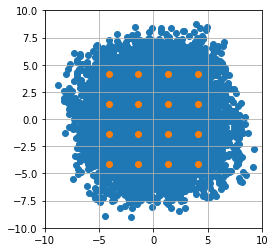

In [212]:
#data_out = k_means(data,36,1000)
C_2 = data_out_2['C']
pC = qam_cstll(K)
plt.scatter(data.real,data.imag)
#plt.scatter(pC.real,pC.imag)
plt.scatter(C_2.real,C_2.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()
plt.draw()

In [0]:
#initiate this channel
N = 10000
y = np.zeros((N,), dtype=complex)
px = data_out_2['px']
delta = data_out_2['Delta']
sigma = data_out_2['sigma2']
numb = np.zeros((K,), dtype=int)
sigma_real = sigma.real
sigma_imag = sigma.imag
noise = sigma_real * np.random.randn(N) + 1j*sigma_imag * np.random.randn(N)
X = np.zeros((N,), dtype=complex)

# initate X
#C_end = qam_cstll(K)
C_end = C_1
cnt_vec = 0
for iik in range(K):
    numb[iik] = np.round(px[iik]*10000)
    for iip in range(numb[iik]):
        X[cnt_vec] = C_end[iik]    
        cnt_vec = cnt_vec + 1




array([ 298,  568,  558,  303,  599, 1042, 1027,  607,  585, 1021, 1006,
        593,  310,  588,  579,  316])

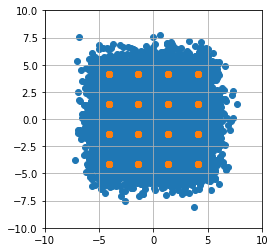

In [213]:
y = delta*X + noise

plt.scatter(y.real,y.imag)
plt.scatter(delta*X.real,delta*X.imag)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()
plt.draw()
numb